In [1]:
import copy
import pandas as pd
import numpy as np

raw_df=pd.read_csv("data.csv")
raw_df

,ticker,date,last,volume
0,1332 JT,2013-01-04,169.0987,1464100
1,1332 JT,2013-01-07,166.3266,1783500
2,1332 JT,2013-01-08,166.3266,1759800
3,1332 JT,2013-01-09,165.4026,767800
4,1332 JT,2013-01-10,167.2507,1503100
...,...,...,...,...
451108,9984 JT,2021-03-15,10370.0000,12041200
451109,9984 JT,2021-03-16,10620.0000,11346000
451110,9984 JT,2021-03-17,10400.0000,9771000
451111,9984 JT,2021-03-18,10220.0000,13941600


### Data Processing and Feature engineering

In [2]:
import talib
from sklearn.linear_model import LinearRegression

def RSRS(df,n=10,m=10):
    df1=copy.deepcopy(df.copy())
    def calculate_beta(df, window=5):
        if df.shape[0] < window:
            return np.nan
        x = df['10days_low'].values
        y = df['10days_high'].values
        beta = LinearRegression().fit(x.reshape(-1, 1), y).coef_[0]
        return beta

    def calculate_rfang(df,window=5):
        if df.shape[0] < window:
            return np.nan
        x = df['10days_low'].values
        y = df['10days_high'].values
        regressor=LinearRegression().fit(x.reshape(-1, 1), y)
        rfang=regressor.score(x.reshape(-1, 1), y)
        return rfang

    df1['beta']= [calculate_beta(data,window=n) for data in df1.rolling(n)]
    df1['rfang']=[calculate_rfang(data,window=n) for data in df1.rolling(n)]
    df1['std_score'] = (df1['beta'] -df1['beta'].rolling(m).mean())/df1['beta'].rolling(m).std()
    df1['rsrs']=df1['std_score']*df1['rfang']
    
    return df1['rsrs']

def flowInratio(df, n=10):
    ret = df.groupby('ticker')['last'].diff(n)
    volume = df.groupby('ticker')['volume'].diff(n)
    turnover = (df.groupby('ticker')['turnover'].diff(n) + 1e-10)
    indicator_pos = (ret > 0) * 1
    indicator_neg = (ret < 0) * 1
    # 基于成交量
    df['FlowInRatio_{}'.format(n)] = (volume * df['last'] * indicator_pos - volume * df['last'] * indicator_neg) / turnover
    return df

def get_factors(data):
    # 转换日期列的数据类型为日期类型
    data['date'] = pd.to_datetime(data['date'])

    # 排序数据并重置索引
    data.sort_values(by=['ticker', 'date'], ascending=True, inplace=True)
    data.reset_index(drop=True, inplace=True)

    # 计算涨跌幅和收益率
    data['return'] = data.groupby('ticker')['last'].pct_change()
    data['price_change'] = data.groupby('ticker')['last'].diff()
    data['volume_perChange'] = data.groupby('ticker')['volume'].pct_change()
    data['volume_change'] = data.groupby('ticker')['volume'].diff()

    # 计算区间最大涨跌幅
    def px_change_max_utils(x, mode):
        if mode == 'high':
            return round((x.loc[x.index[:-1]].max() / x.loc[x.index[-1]] - 1) * 100, 4)
        elif mode == 'low':
            return round((x.loc[x.index[:-1]].min() / x.loc[x.index[-1]] - 1) * 100, 4)

    data['5days_high'] = data.groupby('ticker')['last'].rolling(5).apply(lambda x:px_change_max_utils(x, 'high')).reset_index(level=0,drop=True)
    data['5days_low'] = data.groupby('ticker')['last'].rolling(5).apply(lambda x:px_change_max_utils(x, 'low')).reset_index(level=0,drop=True)
    data['10days_high'] = data.groupby('ticker')['last'].rolling(10).apply(lambda x:px_change_max_utils(x, 'high')).reset_index(level=0,drop=True)
    data['10days_low'] = data.groupby('ticker')['last'].rolling(10).apply(lambda x:px_change_max_utils(x, 'low')).reset_index(level=0,drop=True)
    data['20days_high'] = data.groupby('ticker')['last'].rolling(20).apply(lambda x:px_change_max_utils(x, 'high')).reset_index(level=0,drop=True)
    data['20days_low'] = data.groupby('ticker')['last'].rolling(20).apply(lambda x:px_change_max_utils(x, 'low')).reset_index(level=0,drop=True)

    # 计算滚动均值特征
    data['moving_avg_5'] = data.groupby('ticker')['last'].rolling(window=5).mean().reset_index(level=0, drop=True)
    data['moving_avg_10'] = data.groupby('ticker')['last'].rolling(window=10).mean().reset_index(level=0, drop=True)
    
    # 计算收益率、成交量的波动特征
    data['return_std_5'] = data.groupby('ticker')['return'].rolling(window=5).std().reset_index(level=0, drop=True)
    data['return_std_10'] = data.groupby('ticker')['return'].rolling(window=10).std().reset_index(level=0, drop=True)
    data['return_std_20'] = data.groupby('ticker')['return'].rolling(window=20).std().reset_index(level=0, drop=True)

    data['vol_std_5'] = data.groupby('ticker')['volume'].rolling(window=5).std().reset_index(level=0, drop=True)
    data['vol_std_10'] = data.groupby('ticker')['volume'].rolling(window=10).std().reset_index(level=0, drop=True)
    data['vol_std_20'] = data.groupby('ticker')['volume'].rolling(window=20).std().reset_index(level=0, drop=True)
    
    # 计算成交量相对均值特征
    data['volume_mean'] = data.groupby('ticker')['volume'].transform('mean')
    data['volume_ratio'] = data['volume'] / data['volume_mean']
    
    # 流动性因子
    data['turnover'] = data['volume'] / data['last']
    data=flowInratio(data, n=10)
    data['resiliency_10']=(data['10days_high'] - data['10days_low']) / data['turnover']

    # 计算前5天的收益率特征
    data['return_1'] = data.groupby('ticker')['return'].shift(1)
    data['return_2'] = data.groupby('ticker')['return'].shift(2)
    data['return_3'] = data.groupby('ticker')['return'].shift(3)
    data['return_4'] = data.groupby('ticker')['return'].shift(4)
    data['return_5'] = data.groupby('ticker')['return'].shift(5)

    # 计算不同移动平均线之间的交叉点
    data['moving_avg_50'] = data.groupby('ticker')['last'].rolling(window=50).mean().reset_index(level=0,drop=True)
    data['moving_avg_200'] = data.groupby('ticker')['last'].rolling(window=200).mean().reset_index(level=0,drop=True)

    # 判断移动平均线之间的交叉情况
    data['ma_cross'] = 0
    data.loc[(data['moving_avg_50'] > data['moving_avg_200']) & (data['moving_avg_50'].shift(1) < data['moving_avg_200'].shift(1)), 'ma_cross'] = 1
    data.loc[(data['moving_avg_50'] < data['moving_avg_200']) & (data['moving_avg_50'].shift(1) > data['moving_avg_200'].shift(1)), 'ma_cross'] = -1

    # 计算布林带指标
    data['rolling_mean'] = data.groupby('ticker')['last'].rolling(window=20).mean().reset_index(level=0,drop=True)
    data['rolling_std'] = data.groupby('ticker')['last'].rolling(window=20).std().reset_index(level=0,drop=True)
    data['upper_band'] = data['rolling_mean'] + 2 * data['rolling_std']
    data['lower_band'] = data['rolling_mean'] - 2 * data['rolling_std']

    # 判断价格是否触及布林带
    data['price_touch_upper'] = 0
    data.loc[data['last'] > data['upper_band'], 'price_touch_upper'] = 1

    data['price_touch_lower'] = 0
    data.loc[data['last'] < data['lower_band'], 'price_touch_lower'] = 1

    # 计算相对强弱指标（RSI）
    data['returns_diff'] = data.groupby('ticker')['last'].diff()
    data['upside_returns'] = data['returns_diff'].apply(lambda x: x if x > 0 else 0)
    data['downside_returns'] = data['returns_diff'].apply(lambda x: abs(x) if x < 0 else 0)
    data['avg_gain'] = data.groupby('ticker')['upside_returns'].rolling(window=14).mean().reset_index(level=0,drop=True)
    data['avg_loss'] = data.groupby('ticker')['downside_returns'].rolling(window=14).mean().reset_index(level=0,drop=True)
    data['rs'] = data['avg_gain'] / data['avg_loss']
    data['rsi'] = 100 - (100 / (1 + data['rs']))
    
    # talib RSRS
    # 定义一个函数，用于对每一列进行缺失值的均值填充
    def fillna_mean(group):
        return group.fillna(group.mean())

    # 对每列进行分组并进行缺失值填充
    data = data.groupby('ticker').apply(fillna_mean)
    grouped_data = data.groupby('ticker')

    result = pd.DataFrame()

    # 针对每个股票计算MACD和动量因子
    for stock, stock_data in grouped_data:
        # 计算MACD指标
        macd, macd_signal, macd_hist = talib.MACD(stock_data['last'], fastperiod=12, slowperiod=26, signalperiod=9)
        stock_data['MACD'] = macd  # MACD线
        stock_data['MACD_Signal'] = macd_signal  # MACD信号线
        stock_data['MACD_Hist'] = macd_hist  # MACD柱状图
        
        # 计算动量因子（Momentum）
        momentum = talib.MOM(stock_data['last'], timeperiod=10)
        stock_data['Momentum'] = momentum
        
        # RSRS择时因子
        stock_data['RSRS']=RSRS(stock_data,n=10,m=10)
        
        # 将计算结果添加到result DataFrame中
        result = pd.concat([result, stock_data])
    
    result=result.groupby('ticker').apply(fillna_mean)
    result=result.drop(['returns_diff','upside_returns','downside_returns','avg_gain','avg_loss','rs'],axis=1)

    return result

In [3]:
fac_df=get_factors(raw_df)
fac_df

C:\Users\24366\AppData\Local\Temp\ipykernel_14664\43522944.py:131: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  return group.fillna(group.mean())
C:\Users\24366\AppData\Local\Temp\ipykernel_14664\43522944.py:131: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  return group.fillna(group.mean())
C:\Users\24366\AppData\Local\Temp\ipykernel_14664\43522944.py:131: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  return group.fillna(group.mean())
C:\Users\24366\AppData\Local\Temp\ipykernel_14664\43522944.py:131: FutureWarning: The default value of numeric_only in DataFram

,ticker,date,last,volume,return,price_change,volume_perChange,volume_change,5days_high,5days_low,...,upper_band,lower_band,price_touch_upper,price_touch_lower,rsi,MACD,MACD_Signal,MACD_Hist,Momentum,RSRS
0,1332 JT,2013-01-04,169.0987,1464100,0.000847,0.198554,0.141623,3.659681e+02,1.626217,-1.838862,...,483.607078,422.254483,0,0,52.638336,1.223059,1.181102,0.041957,1.957977,0.125776
1,1332 JT,2013-01-07,166.3266,1783500,-0.016393,-2.772100,0.218154,3.194000e+05,1.626217,-1.838862,...,483.607078,422.254483,0,0,52.638336,1.223059,1.181102,0.041957,1.957977,0.125776
2,1332 JT,2013-01-08,166.3266,1759800,0.000000,0.000000,-0.013288,-2.370000e+04,1.626217,-1.838862,...,483.607078,422.254483,0,0,52.638336,1.223059,1.181102,0.041957,1.957977,0.125776
3,1332 JT,2013-01-09,165.4026,767800,-0.005555,-0.924000,-0.563700,-9.920000e+05,1.626217,-1.838862,...,483.607078,422.254483,0,0,52.638336,1.223059,1.181102,0.041957,1.957977,0.125776
4,1332 JT,2013-01-10,167.2507,1503100,0.011173,1.848100,0.957671,7.353000e+05,1.104900,-1.105000,...,483.607078,422.254483,0,0,52.638336,1.223059,1.181102,0.041957,1.957977,0.125776
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
451108,9984 JT,2021-03-15,10370.0000,12041200,-0.024918,-265.000000,-0.306043,-5.310300e+06,2.555400,-2.410800,...,10729.536967,9787.963033,0,0,48.053528,290.661577,337.227787,-46.566210,-65.000000,0.543874
451109,9984 JT,2021-03-16,10620.0000,11346000,0.024108,250.000000,-0.057735,-6.952000e+05,0.141200,-4.708100,...,10770.724972,9808.275028,0,0,58.368311,299.840485,329.750326,-29.909842,240.000000,0.304483
451110,9984 JT,2021-03-17,10400.0000,9771000,-0.020716,-220.000000,-0.138815,-1.575000e+06,2.259600,-1.057700,...,10768.665103,9808.334897,0,0,50.479583,286.065094,321.013280,-34.948186,-200.000000,-0.106770
451111,9984 JT,2021-03-18,10220.0000,13941600,-0.017308,-180.000000,0.426835,4.170600e+06,4.060700,1.467700,...,10757.087618,9801.412382,0,0,54.837749,257.653433,308.341310,-50.687878,170.000000,-0.388123


In [42]:
fac_df.to_csv("factors.csv")
# fac_df=pd.read_csv("factors.csv")
# fac_df=fac_df.drop(fac_df.columns[:3],axis=1).replace(np.inf, 0).replace(-np.inf, 0)
# fac_df

,last,volume,return,price_change,volume_perChange,volume_change,5days_high,5days_low,10days_high,10days_low,...,upper_band,lower_band,price_touch_upper,price_touch_lower,rsi,MACD,MACD_Signal,MACD_Hist,Momentum,RSRS
0,169.0987,1464100,0.000847,0.198554,0.141623,3.659681e+02,1.626217,-1.838862,3.120333,-3.529818,...,483.607078,422.254483,0,0,52.638336,1.223059,1.181102,0.041957,1.957977,0.125776
1,166.3266,1783500,-0.016393,-2.772100,0.218154,3.194000e+05,1.626217,-1.838862,3.120333,-3.529818,...,483.607078,422.254483,0,0,52.638336,1.223059,1.181102,0.041957,1.957977,0.125776
2,166.3266,1759800,0.000000,0.000000,-0.013288,-2.370000e+04,1.626217,-1.838862,3.120333,-3.529818,...,483.607078,422.254483,0,0,52.638336,1.223059,1.181102,0.041957,1.957977,0.125776
3,165.4026,767800,-0.005555,-0.924000,-0.563700,-9.920000e+05,1.626217,-1.838862,3.120333,-3.529818,...,483.607078,422.254483,0,0,52.638336,1.223059,1.181102,0.041957,1.957977,0.125776
4,167.2507,1503100,0.011173,1.848100,0.957671,7.353000e+05,1.104900,-1.105000,3.120333,-3.529818,...,483.607078,422.254483,0,0,52.638336,1.223059,1.181102,0.041957,1.957977,0.125776
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
451108,10370.0000,12041200,-0.024918,-265.000000,-0.306043,-5.310300e+06,2.555400,-2.410800,2.555400,-5.323000,...,10729.536967,9787.963033,0,0,48.053528,290.661577,337.227787,-46.566210,-65.000000,0.543874
451109,10620.0000,11346000,0.024108,250.000000,-0.057735,-6.952000e+05,0.141200,-4.708100,0.141200,-7.551800,...,10770.724972,9808.275028,0,0,58.368311,299.840485,329.750326,-29.909842,240.000000,0.304483
451110,10400.0000,9771000,-0.020716,-220.000000,-0.138815,-1.575000e+06,2.259600,-1.057700,2.259600,-5.596200,...,10768.665103,9808.334897,0,0,50.479583,286.065094,321.013280,-34.948186,-200.000000,-0.106770
451111,10220.0000,13941600,-0.017308,-180.000000,0.426835,4.170600e+06,4.060700,1.467700,4.060700,-3.933500,...,10757.087618,9801.412382,0,0,54.837749,257.653433,308.341310,-50.687878,170.000000,-0.388123


In [68]:
# calculate labels
def px_change_interval(data):
    """
    区间内最大涨跌幅
    """
    def px_change_max_utils(x, mode):
        if mode == 'high':
            return round((x.loc[x.index[:-1]].max() / x.loc[x.index[-1]] - 1) * 100, 4)
        elif mode == 'low':
            return round((x.loc[x.index[:-1]].min() / x.loc[x.index[-1]] - 1) * 100, 4)

    data_reverse = data.sort_values(by=['ticker', 'date'], ascending=False)
    data_reverse['5days_last_high'] = data_reverse.groupby('ticker')['last'].rolling(6).apply(lambda x:px_change_max_utils(x, 'high')).reset_index(level=0,drop=True)
    data_reverse['5days_return_high'] = data_reverse.groupby('ticker')['return'].rolling(6).apply(lambda x:px_change_max_utils(x, 'high')).reset_index(level=0,drop=True)
    data_reverse['10days_last_high'] = data_reverse.groupby('ticker')['last'].rolling(11).apply(lambda x:px_change_max_utils(x, 'high')).reset_index(level=0,drop=True)
    data_reverse['10days_return_high'] = data_reverse.groupby('ticker')['return'].rolling(11).apply(lambda x:px_change_max_utils(x, 'high')).reset_index(level=0,drop=True)
    data_reverse['20days_last_high'] = data_reverse.groupby('ticker')['last'].rolling(21).apply(lambda x:px_change_max_utils(x, 'high')).reset_index(level=0,drop=True)
    data_reverse['20days_return_high'] = data_reverse.groupby('ticker')['return'].rolling(21).apply(lambda x:px_change_max_utils(x, 'high')).reset_index(level=0,drop=True)
    
    return data_reverse.sort_index()

lab_df=px_change_interval(fac_df[['ticker', 'date', 'last', 'return']])
lab_df=lab_df.replace(np.inf, 0).replace(-np.inf, 0)
lab_df.dropna(axis=0, inplace=True)
lab_df.to_csv("labels.csv")
lab_df

KeyboardInterrupt: 

In [4]:
lab_df=pd.read_csv("labels.csv")
lab_df

,Unnamed: 0,ticker,date,last,return,5days_last_high,5days_return_high,10days_last_high,10days_return_high,20days_last_high,20days_return_high
0,0,1332 JT,2013-01-04,169.0987,0.000847,1.0929,2509.8054,3.2787,3772.0308,3.2787,3772.0308
1,1,1332 JT,2013-01-07,166.3266,-0.016393,5.0000,-234.8054,5.0000,-300.0036,5.0000,-300.0036
2,2,1332 JT,2013-01-08,166.3266,0.000000,5.0000,0.0000,5.0000,0.0000,9.4444,0.0000
3,3,1332 JT,2013-01-09,165.4026,-0.005555,5.5866,-497.8007,5.5866,-690.1959,11.1732,-861.9251
4,4,1332 JT,2013-01-10,167.2507,0.011173,4.4199,193.4427,4.4199,193.4427,9.9447,278.8257
...,...,...,...,...,...,...,...,...,...,...,...
445919,451088,9984 JT,2021-02-12,9797.0000,-0.016464,6.3591,-351.9359,7.4819,-431.4645,8.5536,-431.4645
445920,451089,9984 JT,2021-02-15,10005.0000,0.021231,5.2474,95.3713,5.2474,157.0442,6.2969,157.0442
445921,451090,9984 JT,2021-02-16,10420.0000,0.041479,1.0557,-58.0723,1.7274,31.5670,2.0633,31.5670
445922,451091,9984 JT,2021-02-17,10405.0000,-0.001440,1.2013,-2765.3710,1.8741,-3891.0056,2.2105,-3891.0056


In [5]:
lab_df['date'] = pd.to_datetime(lab_df['date'])
merged_df = pd.merge(fac_df, lab_df[['ticker', 'date','5days_last_high', '5days_return_high', '10days_last_high', '10days_return_high', '20days_last_high', '20days_return_high']], 
                     on=['ticker', 'date'], how='inner')
merged_df

,ticker,date,last,volume,return,price_change,volume_perChange,volume_change,5days_high,5days_low,...,MACD_Signal,MACD_Hist,Momentum,RSRS,5days_last_high,5days_return_high,10days_last_high,10days_return_high,20days_last_high,20days_return_high
0,1332 JT,2013-01-04,169.0987,1464100,0.000847,0.198554,0.141623,3.659681e+02,1.626217,-1.838862,...,1.181102,0.041957,1.957977,0.125776,1.0929,2509.8054,3.2787,3772.0308,3.2787,3772.0308
1,1332 JT,2013-01-07,166.3266,1783500,-0.016393,-2.772100,0.218154,3.194000e+05,1.626217,-1.838862,...,1.181102,0.041957,1.957977,0.125776,5.0000,-234.8054,5.0000,-300.0036,5.0000,-300.0036
2,1332 JT,2013-01-08,166.3266,1759800,0.000000,0.000000,-0.013288,-2.370000e+04,1.626217,-1.838862,...,1.181102,0.041957,1.957977,0.125776,5.0000,0.0000,5.0000,0.0000,9.4444,0.0000
3,1332 JT,2013-01-09,165.4026,767800,-0.005555,-0.924000,-0.563700,-9.920000e+05,1.626217,-1.838862,...,1.181102,0.041957,1.957977,0.125776,5.5866,-497.8007,5.5866,-690.1959,11.1732,-861.9251
4,1332 JT,2013-01-10,167.2507,1503100,0.011173,1.848100,0.957671,7.353000e+05,1.104900,-1.105000,...,1.181102,0.041957,1.957977,0.125776,4.4199,193.4427,4.4199,193.4427,9.9447,278.8257
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
445919,9984 JT,2021-02-12,9797.0000,12837200,-0.016464,-164.000000,-0.275074,-4.871100e+06,1.674000,-7.308400,...,284.028913,119.136324,1512.000000,-1.275193,6.3591,-351.9359,7.4819,-431.4645,8.5536,-431.4645
445920,9984 JT,2021-02-15,10005.0000,12408000,0.021231,208.000000,-0.033434,-4.292000e+05,-0.439800,-5.197400,...,314.827225,123.193250,1897.000000,-1.012908,5.2474,95.3713,5.2474,157.0442,6.2969,157.0442
445921,9984 JT,2021-02-16,10420.0000,14316000,0.041479,415.000000,0.153772,1.908000e+06,-3.982700,-5.978900,...,350.550267,142.892169,1962.000000,-0.710628,1.0557,-58.0723,1.7274,31.5670,2.0633,31.5670
445922,9984 JT,2021-02-17,10405.0000,10469800,-0.001440,-15.000000,-0.268664,-3.846200e+06,0.144200,-5.843300,...,386.449083,143.595262,1845.000000,-0.292315,1.2013,-2765.3710,1.8741,-3891.0056,2.2105,-3891.0056


In [6]:
fac_val_list=['moving_avg_5', 'moving_avg_10', 'return_std_5', 'return_std_10',
       'return_std_20', 'vol_std_5', 'vol_std_10', 'vol_std_20', 'volume_mean',
       'volume_ratio', 'turnover', 'FlowInRatio_10', 'resiliency_10',
       'return_1', 'return_2', 'return_3', 'return_4', 'return_5',
       'moving_avg_50', 'moving_avg_200', 'ma_cross', 'rolling_mean',
       'rolling_std', 'upper_band', 'lower_band', 'price_touch_upper',
       'price_touch_lower', 'rsi', 'MACD', 'MACD_Signal', 'MACD_Hist',
       'Momentum', 'RSRS']

# Extremum removal, Standardization, Normalization
for fac in fac_val_list:
       merged_df[fac]=merged_df[fac].clip(merged_df[merged_df['date'] <= '2020-01-01'][fac].quantile(0.02), merged_df[merged_df['date'] <= '2020-01-01'][fac].quantile(0.98))
       merged_df[fac]=(merged_df[fac]-merged_df[merged_df['date'] <= '2020-01-01'][fac].mean())/merged_df[merged_df['date'] <= '2020-01-01'][fac].std()
       merged_df[fac]=(merged_df[fac]-merged_df[merged_df['date'] <= '2020-01-01'][fac].min())/(merged_df[merged_df['date'] <= '2020-01-01'][fac].max()-merged_df[merged_df['date'] <= '2020-01-01'][fac].min())

In [7]:
# Setting the signal life cycle to 10 days, 
# we forecast the yield at the top of the range within 10 days + the yield on day 10

fac_all_list=['last', 'volume', 'return', 'price_change',
       'volume_perChange', 'volume_change', '5days_high', '5days_low',
       '10days_high', '10days_low', '20days_high', '20days_low',
       'moving_avg_5', 'moving_avg_10', 'return_std_5', 'return_std_10',
       'return_std_20', 'vol_std_5', 'vol_std_10', 'vol_std_20', 'volume_mean',
       'volume_ratio', 'turnover', 'FlowInRatio_10', 'resiliency_10',
       'return_1', 'return_2', 'return_3', 'return_4', 'return_5',
       'moving_avg_50', 'moving_avg_200', 'ma_cross', 'rolling_mean',
       'rolling_std', 'upper_band', 'lower_band', 'price_touch_upper',
       'price_touch_lower', 'rsi', 'MACD', 'MACD_Signal', 'MACD_Hist',
       'Momentum', 'RSRS']

merged_df["{}days_return_at".format(10)]=merged_df.groupby("ticker")['last'].pct_change(-10)
merged_df["10_high_at"]=merged_df["{}days_return_at".format(10)]+merged_df["{}days_return_high".format(10)]
merged_df=merged_df.replace(np.inf, 0).replace(-np.inf, 0)
merged_df.dropna(subset="10_high_at",how='any',axis=0,inplace=True)
y_train_full = merged_df[merged_df['date'] <= '2020-01-01']["10_high_at"]
x_train_full = merged_df[merged_df['date'] <= '2020-01-01'][fac_all_list]
x_train_full

,last,volume,return,price_change,volume_perChange,volume_change,5days_high,5days_low,10days_high,10days_low,...,upper_band,lower_band,price_touch_upper,price_touch_lower,rsi,MACD,MACD_Signal,MACD_Hist,Momentum,RSRS
0,169.0987,1464100,0.000847,0.198554,0.141623,3.659681e+02,1.626217,-1.838862,3.120333,-3.529818,...,0.010812,0.011034,0.0,0.0,0.510423,0.456731,0.450134,0.512769,0.486342,0.452828
1,166.3266,1783500,-0.016393,-2.772100,0.218154,3.194000e+05,1.626217,-1.838862,3.120333,-3.529818,...,0.010812,0.011034,0.0,0.0,0.510423,0.456731,0.450134,0.512769,0.486342,0.452828
2,166.3266,1759800,0.000000,0.000000,-0.013288,-2.370000e+04,1.626217,-1.838862,3.120333,-3.529818,...,0.010812,0.011034,0.0,0.0,0.510423,0.456731,0.450134,0.512769,0.486342,0.452828
3,165.4026,767800,-0.005555,-0.924000,-0.563700,-9.920000e+05,1.626217,-1.838862,3.120333,-3.529818,...,0.010812,0.011034,0.0,0.0,0.510423,0.456731,0.450134,0.512769,0.486342,0.452828
4,167.2507,1503100,0.011173,1.848100,0.957671,7.353000e+05,1.104900,-1.105000,3.120333,-3.529818,...,0.010812,0.011034,0.0,0.0,0.510423,0.456731,0.450134,0.512769,0.486342,0.452828
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
445645,4637.3682,11253100,0.003646,16.845200,0.306571,2.640400e+06,0.491500,-1.559800,0.491500,-8.354700,...,0.432804,0.404793,0.0,0.0,1.000000,0.822372,0.694939,0.954261,0.929653,0.405988
445646,4602.6870,6840900,-0.007479,-34.681200,-0.392088,-4.412200e+06,1.248700,0.387500,1.248700,-6.695400,...,0.435797,0.405803,0.0,0.0,0.971568,0.825822,0.724737,0.874824,0.896088,0.408852
445647,4658.1769,8905400,0.012056,55.489900,0.301788,2.064500e+06,-0.446700,-1.191200,0.042500,-6.658200,...,0.439425,0.406527,0.0,0.0,0.990022,0.839136,0.751416,0.836872,0.908819,0.409828
445648,4726.5483,11769500,0.014678,68.371400,0.321614,2.864100e+06,-1.446500,-2.620500,-1.404600,-6.582800,...,0.443771,0.407376,0.0,0.0,0.996102,0.863477,0.777951,0.835125,0.926180,0.411548


In [8]:
y_test = merged_df[merged_df['date'] > '2020-01-01']["10_high_at"]
x_test = merged_df[merged_df['date'] > '2020-01-01'][fac_all_list]
x_test

,last,volume,return,price_change,volume_perChange,volume_change,5days_high,5days_low,10days_high,10days_low,...,upper_band,lower_band,price_touch_upper,price_touch_lower,rsi,MACD,MACD_Signal,MACD_Hist,Momentum,RSRS
1711,618.0937,2214800,-0.035276,-22.6012,0.489642,728000.0,4.1335,3.0207,4.4515,1.2718,...,0.028618,0.031290,0.0,0.0,0.327454,0.459692,0.459369,0.494289,0.440439,0.317959
1712,625.9549,1809400,0.012718,7.8612,-0.183041,-405400.0,2.8257,-1.2559,3.1397,-1.2559,...,0.028614,0.031242,0.0,0.0,0.502663,0.456574,0.457519,0.489801,0.467985,0.359177
1713,609.2497,3382900,-0.026688,-16.7052,0.869625,1573500.0,5.6452,1.4516,5.9678,1.4516,...,0.028710,0.031005,0.0,0.0,0.300319,0.449611,0.454553,0.476234,0.464542,0.292998
1714,618.0937,2195500,0.014516,8.8440,-0.351001,-1187400.0,3.6566,-1.4309,4.4515,-1.4309,...,0.028629,0.031191,0.0,0.0,0.236883,0.446559,0.451529,0.475529,0.470281,0.362919
1715,616.1283,1632300,-0.003180,-1.9654,-0.256525,-563200.0,1.5949,-1.1164,4.7847,-1.1164,...,0.028541,0.031375,0.0,0.0,0.240816,0.443710,0.448503,0.475494,0.463394,0.421631
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
445909,8285.0000,16688800,-0.035955,-309.0000,1.056943,8575400.0,6.2161,3.7296,7.9783,2.6313,...,0.863348,0.818655,0.0,0.0,0.585754,1.000000,1.000000,0.123495,0.152332,0.315086
445910,8108.0000,14133300,-0.021364,-177.0000,-0.153127,-2555500.0,6.8698,2.1830,10.3355,2.1830,...,0.863085,0.819530,0.0,0.0,0.514514,1.000000,1.000000,0.000000,0.005159,0.424110
445911,8458.0000,11180200,0.043167,350.0000,-0.208946,-2953100.0,2.4474,-4.1381,5.7697,-4.1381,...,0.863237,0.823777,0.0,0.0,0.587377,0.963390,1.000000,0.000000,0.431493,0.536356
445912,8560.0000,11823800,0.012060,102.0000,0.057566,643600.0,0.3972,-5.2804,4.5093,-5.2804,...,0.863394,0.829693,0.0,0.0,0.551299,0.952829,1.000000,0.000000,0.252783,0.586853


### xgboost modeling

In [9]:
from sklearn.model_selection import train_test_split

x_train, x_val, y_train, y_val=train_test_split(x_train_full, y_train_full, test_size=0.15, random_state=42)

print("shapes of x_train, x_val and x_test are: {},{},{}".format(x_train.shape,x_val.shape,x_test.shape))

shapes of x_train, x_val and x_test are: (326549, 45),(57627, 45),(59268, 45)


In [10]:
import xgboost as xgb

class my_xgb: 
    def __init__(self,params):
        self.params=params
                
    def run_model(self,X_train, X_val, y_train, y_val,w=8,mode='reg'):
        if mode=="cls":
            weights=np.where(y_train==1,w,1)
            train=xgb.DMatrix(X_train,label= y_train,weight=weights)
        else:
            train=xgb.DMatrix(X_train, label= y_train)
        valid=xgb.DMatrix(X_val,label=y_val)
        bst=xgb.train(self.params,train,num_boost_round=1000,evals=[(train,'train'),(valid,'valid')],early_stopping_rounds=10)
        self.model=bst

In [11]:
pr_reg = {
    'objective': 'reg:squarederror',  # 回归任务采用平方误差作为损失函数
    'eval_metric': 'rmse',  # 评估指标设置为均方根误差
    'learning_rate': 0.08,  # 学习率
    'max_depth': 6,  # 树的最大深度
    'min_child_weight': 1,  # 节点分裂所需的最小样本数
    'gamma': 0.1,  # 最小分裂损失的减少值
    'subsample': 0.7,  # 每个树的训练样本占总样本的比例
    'colsample_bytree': 0.7  # 每棵树在特征选择上的采样比例
}
myxgb=my_xgb(params=pr_reg)
myxgb.run_model(x_train, x_val, y_train, y_val)
yhat=myxgb.model.predict(xgb.DMatrix(x_test[x_train.columns]))
yhat=yhat.reshape(len(yhat), 1)

df_new=merged_df[merged_df['date'] > '2020-01-01'].copy()
df_new["pred"]=yhat
df_new["y_test"]=y_test
df_new

[0]	train-rmse:216246.80043	valid-rmse:214435.73921
[1]	train-rmse:206549.53813	valid-rmse:211459.75735
[2]	train-rmse:197877.69383	valid-rmse:205957.53538
[3]	train-rmse:189100.29119	valid-rmse:200750.49440
[4]	train-rmse:184948.00768	valid-rmse:194846.97389
[5]	train-rmse:177252.23300	valid-rmse:193400.06445
[6]	train-rmse:169380.07651	valid-rmse:188890.20103
[7]	train-rmse:162929.13266	valid-rmse:186740.11236
[8]	train-rmse:155987.85127	valid-rmse:186017.82721
[9]	train-rmse:149039.17662	valid-rmse:183429.68059
[10]	train-rmse:142200.59043	valid-rmse:178903.95169
[11]	train-rmse:136250.17088	valid-rmse:177262.62808
[12]	train-rmse:130734.26241	valid-rmse:175769.03622
[13]	train-rmse:125102.12900	valid-rmse:175172.09278
[14]	train-rmse:120038.02361	valid-rmse:172883.96308
[15]	train-rmse:115100.99125	valid-rmse:168492.22508
[16]	train-rmse:110413.31127	valid-rmse:168430.90050
[17]	train-rmse:108688.32724	valid-rmse:166930.14575
[18]	train-rmse:104434.56644	valid-rmse:166694.41205
[19

,ticker,date,last,volume,return,price_change,volume_perChange,volume_change,5days_high,5days_low,...,5days_last_high,5days_return_high,10days_last_high,10days_return_high,20days_last_high,20days_return_high,10days_return_at,10_high_at,pred,y_test
1711,1332 JT,2020-01-06,618.0937,2214800,-0.035276,-22.6012,0.489642,728000.0,4.1335,3.0207,...,1.2718,-141.1503,1.2718,-141.1503,1.2718,-143.0234,0.029460,-141.120840,-329.797302,-141.120840
1712,1332 JT,2020-01-07,625.9549,1809400,0.012718,7.8612,-0.183041,-405400.0,2.8257,-1.2559,...,-1.2559,14.1350,-1.2559,14.1350,-1.2559,357.7538,0.029079,14.164079,219.209473,14.164079
1713,1332 JT,2020-01-08,609.2497,3382900,-0.026688,-16.7052,0.869625,1573500.0,5.6452,1.4516,...,1.4516,-154.3932,1.4516,-154.3932,1.4516,-318.1513,0.026490,-154.366710,-340.134918,-154.366710
1714,1332 JT,2020-01-09,618.0937,2195500,0.014516,8.8440,-0.351001,-1187400.0,3.6566,-1.4309,...,-0.3180,-77.6339,-0.3180,-9.8033,-0.3180,301.0635,0.046589,-9.756711,233.545425,-9.756711
1715,1332 JT,2020-01-10,616.1283,1632300,-0.003180,-1.9654,-0.256525,-563200.0,1.5949,-1.1164,...,-0.1595,-202.1052,-0.1595,-511.7630,-0.1595,-1930.9221,0.052013,-511.710987,-946.763977,-511.710987
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
445909,9984 JT,2021-01-28,8285.0000,16688800,-0.035955,-309.0000,1.056943,8575400.0,6.2161,3.7296,...,5.9264,-220.0580,20.2293,-223.7327,27.0972,-251.7801,-0.154333,-223.887033,-214.744232,-223.887033
445910,9984 JT,2021-01-29,8108.0000,14133300,-0.021364,-177.0000,-0.153127,-2555500.0,6.8698,2.1830,...,12.0005,-302.0568,23.3966,-308.2413,29.8717,-355.4449,-0.189605,-308.430905,-227.098450,-308.430905
445911,9984 JT,2021-02-01,8458.0000,11180200,0.043167,350.0000,-0.208946,-2953100.0,2.4474,-4.1381,...,12.1424,3.0608,23.1970,3.0608,25.3251,26.4223,-0.188292,2.872508,174.630585,2.872508
445912,9984 JT,2021-02-02,8560.0000,11823800,0.012060,102.0000,0.057566,643600.0,0.3972,-5.2804,...,14.5794,268.9056,21.7290,268.9056,23.8318,352.5280,-0.177319,268.728281,187.293198,268.728281


In [12]:
len(y_train[y_train>250])/len(y_train)

0.17974944035963974

In [13]:
pr_cls={'objective':'binary:logistic',
    'eval_metric':"aucpr",
    'colsample_bytree':0.7,
    'max_depth':5,
    'learning_rate': 0.08,
    'alpha':5,
    'gamma':10, #防止过拟合
    'eta':0.1, #防止过拟合
    "subsample":0.8, #防止过拟合
    "lambda":1 #防止过拟合
    }
y_test2=np.where(y_test>250,1,0)
y_train2=np.where(y_train>250,1,0)
y_val2=np.where(y_val>250,1,0)
myxgb2=my_xgb(params=pr_cls)
myxgb2.run_model(x_train, x_val, y_train2, y_val2,w=6,mode="cls")
yhat2=myxgb2.model.predict(xgb.DMatrix(x_test[x_train.columns]))
yhat2=yhat2.reshape(len(yhat2), 1)

df_new2=merged_df[merged_df['date'] > '2020-01-01'].copy()
df_new2["pred"]=yhat2
df_new2["y_test"]=y_test2
df_new2

[0]	train-aucpr:0.97449	valid-aucpr:0.87551
[1]	train-aucpr:0.97263	valid-aucpr:0.86640
[2]	train-aucpr:0.97415	valid-aucpr:0.87304
[3]	train-aucpr:0.97304	valid-aucpr:0.86790
[4]	train-aucpr:0.97392	valid-aucpr:0.87173
[5]	train-aucpr:0.97500	valid-aucpr:0.87745
[6]	train-aucpr:0.97566	valid-aucpr:0.88028
[7]	train-aucpr:0.97600	valid-aucpr:0.88193
[8]	train-aucpr:0.97606	valid-aucpr:0.88289
[9]	train-aucpr:0.97639	valid-aucpr:0.88429
[10]	train-aucpr:0.97648	valid-aucpr:0.88469
[11]	train-aucpr:0.97670	valid-aucpr:0.88560
[12]	train-aucpr:0.97686	valid-aucpr:0.88635
[13]	train-aucpr:0.97699	valid-aucpr:0.88692
[14]	train-aucpr:0.97715	valid-aucpr:0.88776
[15]	train-aucpr:0.97713	valid-aucpr:0.88733
[16]	train-aucpr:0.97700	valid-aucpr:0.88673
[17]	train-aucpr:0.97720	valid-aucpr:0.88761
[18]	train-aucpr:0.97718	valid-aucpr:0.88714
[19]	train-aucpr:0.97734	valid-aucpr:0.88786
[20]	train-aucpr:0.97749	valid-aucpr:0.88862
[21]	train-aucpr:0.97747	valid-aucpr:0.88846
[22]	train-aucpr:0.9

,ticker,date,last,volume,return,price_change,volume_perChange,volume_change,5days_high,5days_low,...,5days_last_high,5days_return_high,10days_last_high,10days_return_high,20days_last_high,20days_return_high,10days_return_at,10_high_at,pred,y_test
1711,1332 JT,2020-01-06,618.0937,2214800,-0.035276,-22.6012,0.489642,728000.0,4.1335,3.0207,...,1.2718,-141.1503,1.2718,-141.1503,1.2718,-143.0234,0.029460,-141.120840,0.000103,0
1712,1332 JT,2020-01-07,625.9549,1809400,0.012718,7.8612,-0.183041,-405400.0,2.8257,-1.2559,...,-1.2559,14.1350,-1.2559,14.1350,-1.2559,357.7538,0.029079,14.164079,0.651901,0
1713,1332 JT,2020-01-08,609.2497,3382900,-0.026688,-16.7052,0.869625,1573500.0,5.6452,1.4516,...,1.4516,-154.3932,1.4516,-154.3932,1.4516,-318.1513,0.026490,-154.366710,0.000105,0
1714,1332 JT,2020-01-09,618.0937,2195500,0.014516,8.8440,-0.351001,-1187400.0,3.6566,-1.4309,...,-0.3180,-77.6339,-0.3180,-9.8033,-0.3180,301.0635,0.046589,-9.756711,0.492836,0
1715,1332 JT,2020-01-10,616.1283,1632300,-0.003180,-1.9654,-0.256525,-563200.0,1.5949,-1.1164,...,-0.1595,-202.1052,-0.1595,-511.7630,-0.1595,-1930.9221,0.052013,-511.710987,0.000131,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
445909,9984 JT,2021-01-28,8285.0000,16688800,-0.035955,-309.0000,1.056943,8575400.0,6.2161,3.7296,...,5.9264,-220.0580,20.2293,-223.7327,27.0972,-251.7801,-0.154333,-223.887033,0.000082,0
445910,9984 JT,2021-01-29,8108.0000,14133300,-0.021364,-177.0000,-0.153127,-2555500.0,6.8698,2.1830,...,12.0005,-302.0568,23.3966,-308.2413,29.8717,-355.4449,-0.189605,-308.430905,0.000098,0
445911,9984 JT,2021-02-01,8458.0000,11180200,0.043167,350.0000,-0.208946,-2953100.0,2.4474,-4.1381,...,12.1424,3.0608,23.1970,3.0608,25.3251,26.4223,-0.188292,2.872508,0.013778,0
445912,9984 JT,2021-02-02,8560.0000,11823800,0.012060,102.0000,0.057566,643600.0,0.3972,-5.2804,...,14.5794,268.9056,21.7290,268.9056,23.8318,352.5280,-0.177319,268.728281,0.441001,1


### Backtest

Strategy description:

1) Judgment signal: If it is a classification model, the probability that the model predicts that the label of this time is 1 is greater than signal_threshold, then the signal of this time is 1.

   If it is a regression model, the model predicts that the label of this time is greater than signal_threshold, then the signal of this time is 1. Open a position at the last close of the day when the signal is 1.

2) Set the profit stop point: after opening the position, close the position when reaching the profit stop point zhiying. If the end of the signal life cycle has not reached the profit stop point, close the position at the end of the life cycle.

3) Extend the signal life cycle: label_name determines the initial signal life cycle, which takes 10 days. If the previous signal has not reached the profit point at the end of the life cycle, and a new signal appears at that time, the new signal does not open the position, and the original signal is not closed.

4) Portfolio management: By training the data in the set, the variance of each stock and the covariance between them are obtained, and a weight is set for each stock to minimize the variance of the portfolio.

In [14]:
var_grouped=raw_df[raw_df['date'] <= '2020-01-01'].groupby("ticker")["return"].var()
var_dict={}
for name, var in var_grouped.items():
    var_dict[name]=var
var_dict

{'1332 JT': 0.0004835090640805179,
 '1333 JT': 0.0002469366220013078,
 '1334 JT': 0.0003307400530650202,
 '1605 JT': 0.0004227863623134037,
 '1721 JT': 0.00029571637358612353,
 '1801 JT': 0.00033813658895982633,
 '1802 JT': 0.0003225618549366765,
 '1803 JT': 0.00032461296862975887,
 '1808 JT': 0.0003780095157615602,
 '1812 JT': 0.00035645287990119406,
 '1925 JT': 0.000324330320132061,
 '1928 JT': 0.00025078956070296937,
 '1963 JT': 0.00048749553463842674,
 '2002 JT': 0.00025325176054448955,
 '2269 JT': 0.00030615961753379485,
 '2282 JT': 0.00029410427183673406,
 '2413 JT': 0.000262021242223777,
 '2432 JT': 0.00046183270329329173,
 '2501 JT': 0.0003155380904417856,
 '2502 JT': 0.0002565350958464356,
 '2503 JT': 0.0002793634371290623,
 '2531 JT': 0.00048675208226585875,
 '2768 JT': 0.00033122845319634946,
 '2801 JT': 0.0003493352124115519,
 '2802 JT': 0.000271276017925137,
 '2871 JT': 0.00034515200905123144,
 '2914 JT': 0.00024151613354184164,
 '3086 JT': 0.00042535061368619383,
 '3099 J

In [15]:
import scipy.optimize as opt
from scipy.optimize import minimize

df_tmp= raw_df.pivot(index='date', columns='ticker', values='return')

# 生成随机的初始权重
weights = np.random.uniform(size=len(df_tmp.columns))
weights /= np.sum(weights)  # 确保权重总和为1

# 计算协方差矩阵
cov_matrix = df_tmp.cov().fillna(0)

# 定义目标函数（即方差）
def portfolio_variance(weights):
    return np.dot(weights, np.dot(cov_matrix, weights))

# 定义约束条件，权重之和为1
cons = ({'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1})

# 定义优化问题
opt_result = minimize(portfolio_variance, weights, method='SLSQP', constraints=cons)

# 输出优化结果
optimized_weights = opt_result.x
optimized_variance = opt_result.fun
print("最小方差权重分配为:")
for ticker, weight in zip(df_tmp.columns, optimized_weights):
    print(ticker, ":", weight)
print("最小方差为:", optimized_variance)

最小方差权重分配为:
1332 JT : 0.006723619165122809
1333 JT : 0.019671466173218237
1334 JT : 0.009929264541081131
1605 JT : 0.0016379415847201483
1721 JT : 0.013049551965640971
1801 JT : 0.00886592111330746
1802 JT : 0.004385758749953133
1803 JT : 0.010853984768674127
1808 JT : 0.007864129521078421
1812 JT : 0.006792751745554165
1925 JT : 0.004782759864812488
1928 JT : 0.008677635766317908
1963 JT : -0.0026175572627145484
2002 JT : 0.009854022033967826
2269 JT : 0.022430972577695805
2282 JT : 0.015554708619127958
2413 JT : 0.022198263327009537
2432 JT : 0.01726924732652395
2501 JT : 0.009426589117484814
2502 JT : 0.011457025423235831
2503 JT : 0.016151022928478066
2531 JT : -0.002458374835693399
2768 JT : 0.004038833961703662
2801 JT : 0.005682980477976179
2802 JT : 0.01874692219098962
2871 JT : 0.02021058492500817
2914 JT : 0.012939602679816548
3086 JT : -0.0012578531462745187
3099 JT : 0.0031306266671109373
3101 JT : 0.007477281699699651
3103 JT : -0.0016806646916463048
3105 JT : -0.0104607070

In [16]:
# Portfolio weight
port_wgt=pd.DataFrame(optimized_weights,index=df_tmp.columns,columns=["weight"])
port_wgt

,weight
ticker,
1332 JT,0.006724
1333 JT,0.019671
1334 JT,0.009929
1605 JT,0.001638
1721 JT,0.013050
...,...
9681 JT,0.007472
9735 JT,0.015912
9766 JT,0.004642


In [18]:
class backtestclass:
    def __init__(self, df):
        self.df=df
    def get_backtest_result(self, signal_threshold, zhiying, port_wgt=port_wgt, period=10,ext=False):
        df=self.df.copy()
        df["{}days_return_high".format(period)]=df["{}days_return_high".format(period)]/100
        df["{}days_return_at".format(period)]=df["{}days_return_at".format(period)]/100
        df['signal']=np.where(df["pred"]>signal_threshold,1,0) 
        df['weight']=df['ticker'].map(port_wgt['weight'])

        df['ycls']=np.where(df["{}days_return_high".format(period)] > zhiying, 1, 0)
        df['y_up']=np.where(df["{}days_return_high".format(period)] > zhiying, 1, np.where( df["{}days_return_at".format(period)] > 0, 1, 0))

        y_pred = np.array(df['signal'])
        y_true = np.array(df['ycls'])
        y_up=np.array(df['y_up'])
        # Calculate true positives and false positives
        true_positives = np.sum((y_pred == 1) & (y_true == 1))
        false_positives = np.sum((y_pred == 1) & (y_true != 1))
        up_positives = np.sum((y_pred == 1) & (y_up == 1))
        precision = true_positives / (true_positives + false_positives)
        
        up_precision= up_positives/(up_positives+np.sum((y_pred == 1) & (y_up != 1)))
        print("precision: {}, direction precision: {}".format(precision,up_precision))

        # 关仓的时候看一下有没有新信号，有就不关仓，不开新仓，没有就关
        if ext==True:
            df["extend"] = np.where((df['signal'] == 1)&(df["{}days_return_high".format(period)]<zhiying)&(df["signal"].shift(-period)==1)&(df["ticker"].shift(-period)==df["ticker"]),1,0)
            df['return'] = np.where(df['signal'] == 1, np.where(df["{}days_return_high".format(period)] > zhiying, zhiying, 
                                                                np.where(df["extend"]==0,df["{}days_return_at".format(period)],
                                                                            np.where(((df["{}days_return_high".format(period)].shift(-period)+1)* df['last'].shift(-period)/df['last']-1)> zhiying, zhiying, 
                                                                                    df['last'].shift(-2*period)/df['last']-1))),0)
            df['return']=df['return']*df['weight']
            df['signal']=np.where(df["extend"].shift(period)==1,0,df['signal'])
            df['position']=df['weight']*df["signal"]
        else:
            df['return'] = np.where(df['signal'] == 1, np.where(df["{}days_return_high".format(period)] > zhiying, zhiying, df["{}days_return_at".format(period)]),0)
        
        df["all_position_cum"]=abs(df['position']).cumsum()
        df["all_cum_return"] = df['return'].cumsum()
        df["all_return_percentile"]=df["all_cum_return"]/df["all_position_cum"]
        
        self.precision,self.direct_precision=precision,up_precision
        self.dfbacktest=df

In [19]:
log_bt=[]
canshu_list=["mode","signal_threshold","zhiying","extend","precision",
             "direct_precision","all_return_percentile","all_cum_return",'all_signal_cum']

In [23]:
# backtest reg
bt=backtestclass(df_new)
zhiying_= 1.8
signal_th= 270 #That's a forecast yield of 250%
extend=True

bt.get_backtest_result(signal_threshold=signal_th, zhiying=zhiying_, period=10,ext=extend)

log_bt.append(["reg",signal_th,zhiying_,extend,bt.precision,bt.direct_precision,
            bt.dfbacktest.loc[bt.dfbacktest.index[-1],"all_return_percentile"],bt.dfbacktest.loc[bt.dfbacktest.index[-1],"all_cum_return"],
            bt.dfbacktest.loc[bt.dfbacktest.index[-1],'all_position_cum']])
bt_log_df=pd.DataFrame(log_bt,columns=canshu_list)
bt_log_df

precision: 0.8341649856672683, direction precision: 0.9519057224758467


,mode,signal_threshold,zhiying,extend,precision,direct_precision,all_return_percentile,all_cum_return,all_signal_cum
0,reg,270,1.7,True,0.840854,0.954348,0.924159,66.245068,71.681444
1,reg,270,1.8,True,0.834165,0.951906,0.970530,69.491215,71.601319


In [29]:
bt_log_df.to_csv("backtest_result.csv")

<AxesSubplot:>

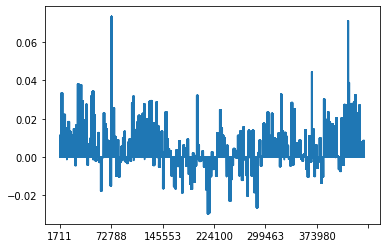

In [22]:
bt.dfbacktest.index=bt.dfbacktest.index.astype(str)
bt.dfbacktest["return"].plot()

In [ ]:
bt.dfbacktest["all_cum_return"].plot()

In [ ]:
bt.dfbacktest['pred'].plot()
(bt.dfbacktest['y_bidprice_current']-2.8).plot()

In [27]:
# backtest cls
bt2=backtestclass(df_new2)
zhiying_= 1.7
signal_th= 0.87
extend=True

bt2.get_backtest_result(signal_threshold=signal_th, zhiying=zhiying_, period=10,ext=extend)

log_bt.append(["cls",signal_th,zhiying_,extend,bt.precision,bt.direct_precision,
            bt2.dfbacktest.loc[bt.dfbacktest.index[-1],"all_return_percentile"],bt2.dfbacktest.loc[bt.dfbacktest.index[-1],"all_cum_return"],
            bt2.dfbacktest.loc[bt.dfbacktest.index[-1],'all_position_cum']])
bt_log_df=pd.DataFrame(log_bt,columns=canshu_list)
bt_log_df

precision: 0.9196035242290749, direction precision: 0.9911894273127754


,mode,signal_threshold,zhiying,extend,precision,direct_precision,all_return_percentile,all_cum_return,all_signal_cum
0,reg,270.00,1.7,True,0.840854,0.954348,0.924159,66.245068,71.681444
1,reg,270.00,1.8,True,0.834165,0.951906,0.970530,69.491215,71.601319
2,cls,0.85,1.6,True,0.834165,0.951906,0.906658,59.624134,65.762554
3,cls,0.83,1.6,True,0.834165,0.951906,0.895063,61.142735,68.311103
4,cls,0.87,1.6,True,0.834165,0.951906,0.912681,57.581241,63.090240
5,cls,0.87,1.7,True,0.834165,0.951906,0.962018,60.610746,63.003731


In [28]:
ind="cls"
bt.dfbacktest.to_csv("backtest_"+ind+".csv")
ind="reg"
bt2.dfbacktest.to_csv("backtest_"+ind+".csv")